# Bag of Words Sentiment Analyse von McDonalds Reviews

## Zielsetzung:
Die Reviews haben die Labels '1 star', '2 stars', '3 stars', '4 stars' und '5 stars'. 
Das reine Raten, wie der Reviewer bewertet hat, würde eine 20% Prozentige Trefferwahrscheinlichkeit haben. Dieses Benchmarkt muss unsere Analyse mindestens knacken um Sinnvoll zu sein. 

Alle Imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import TextVectorization
from tensorflow import keras
from keras import layers
import seaborn as sns
sns.set()

# use graphics in retina format
%config InlineBackend.figure_format = 'retina'

2023-07-03 02:49:43.527146: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 02:49:43.553497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 02:49:43.935850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Datenvorbereitung inkl. Behandlung bekannter Probleme

### Laden der Daten

In [2]:
import os
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unziping dataset...")
    !unzip -n mcdonalds-store-reviews.zip

Unziping dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  mcdonalds-store-reviews.zip


In [3]:
df = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


### Encoding der Daten


#### Umgang mit Strings als Label
Star Ratings werden gerade noch als 1 Star String bis zu einem 5 star String gespeichert. Mit einem numerischen System können neuronale Netzwerke besser umgehen, deshalb formatiere ich die labels zu interges zwischen 1 und 5.

In [4]:
train_data = df['review'].to_numpy()
label_data_strings = df['rating']
label_data = np.array([int(item.split()[0]) for item in label_data_strings])

Um die Verteilung der Ratings besser zu verstehen koennen wir die Daten visualieren.

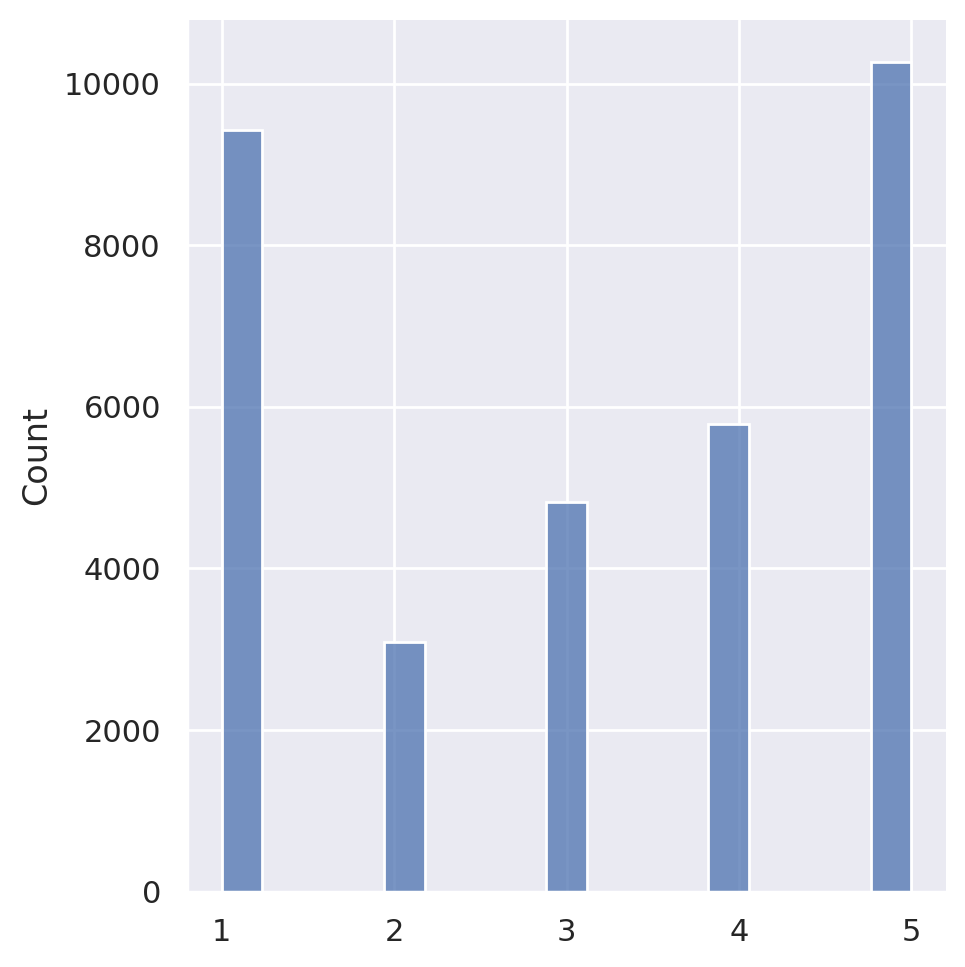

In [5]:
sns.displot(label_data)

### Aufteilung in Trainings und Validierungsdaten 

In [6]:
train_data, test_data, train_label, test_label = train_test_split(train_data, label_data, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(26716,)
(6680,)
(26716,)
(6680,)


### Text zu Dictonary Repräsentationen umbauen
Erklärung Menge an Tokens
Erklärung ngrams 
Erklärung multi_hot und warum

In [7]:
text_vectorization = TextVectorization(
    max_tokens=30000,
    ngrams=3,
    output_mode="multi_hot",
)

2023-07-03 02:49:55.072650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 02:49:55.089598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 02:49:55.089708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
text_vectorization.adapt(train_data) 
text_vectorization.adapt(test_data) 

multi_hot_train_data = text_vectorization(train_data)
multi_hot_test_data = text_vectorization(test_data)

### Hot Encoding der Lables

In [9]:
train_label_one_hot = tf.one_hot(train_label, 5)
train_label_one_hot.shape

TensorShape([26716, 5])

## Erstellung eines entsprechenden künstlichen neuronalen Models sowie geeigente Benchmarks

In [10]:
def get_model(max_tokens=30000, hidden_dim=64):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dense(32, activation="relu")(x)
 x = layers.Dropout(0.5)(x)
 x = layers.Dense(16, activation="relu")(x)
 outputs = layers.Dense(5, activation="softmax")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"], 
 )
 return model

model = get_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 64)                1920064   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,922,757
Trainable params: 1,922,757
Non-train

## Durchführung von In-sample und Out-of-sample Prognosen sowie Bestimmungen sowie Bestimmung der Prognossegüter anhand geeigneter Metriken 

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]
history = model.fit(multi_hot_train_data, train_label_one_hot, validation_split=0.4, epochs=10, callbacks= callbacks)

Epoch 1/10
501/501 [==============================] - 3s 7ms/step - loss: 0.1709 - accuracy: 0.5558 - val_loss: 0.2657 - val_accuracy: 0.4772
Epoch 2/10
501/501 [==============================] - 4s 7ms/step - loss: 0.1422 - accuracy: 0.5867 - val_loss: 0.2831 - val_accuracy: 0.4687
Epoch 3/10
501/501 [==============================] - 3s 5ms/step - loss: 0.1207 - accuracy: 0.6095 - val_loss: 0.3233 - val_accuracy: 0.4761
Epoch 4/10
501/501 [==============================] - 3s 6ms/step - loss: 0.1009 - accuracy: 0.6234 - val_loss: 0.3511 - val_accuracy: 0.4720


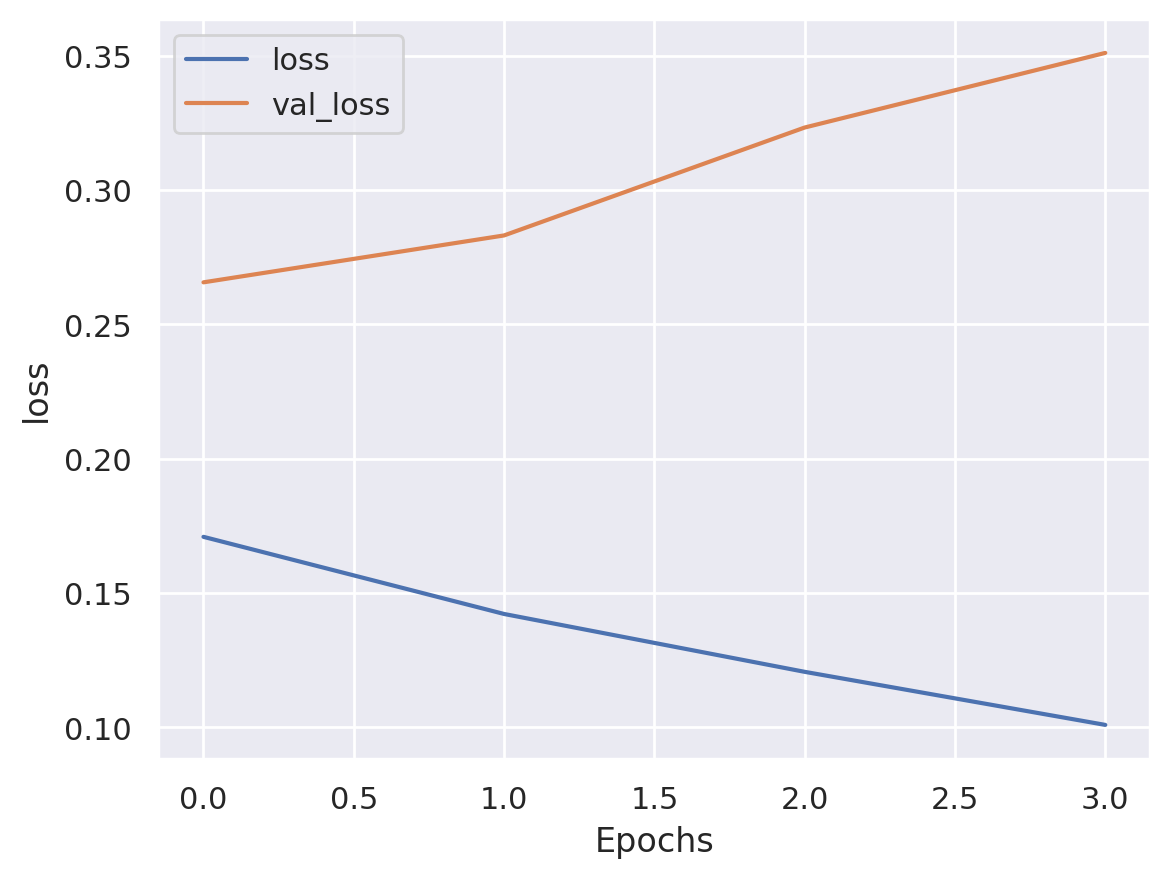

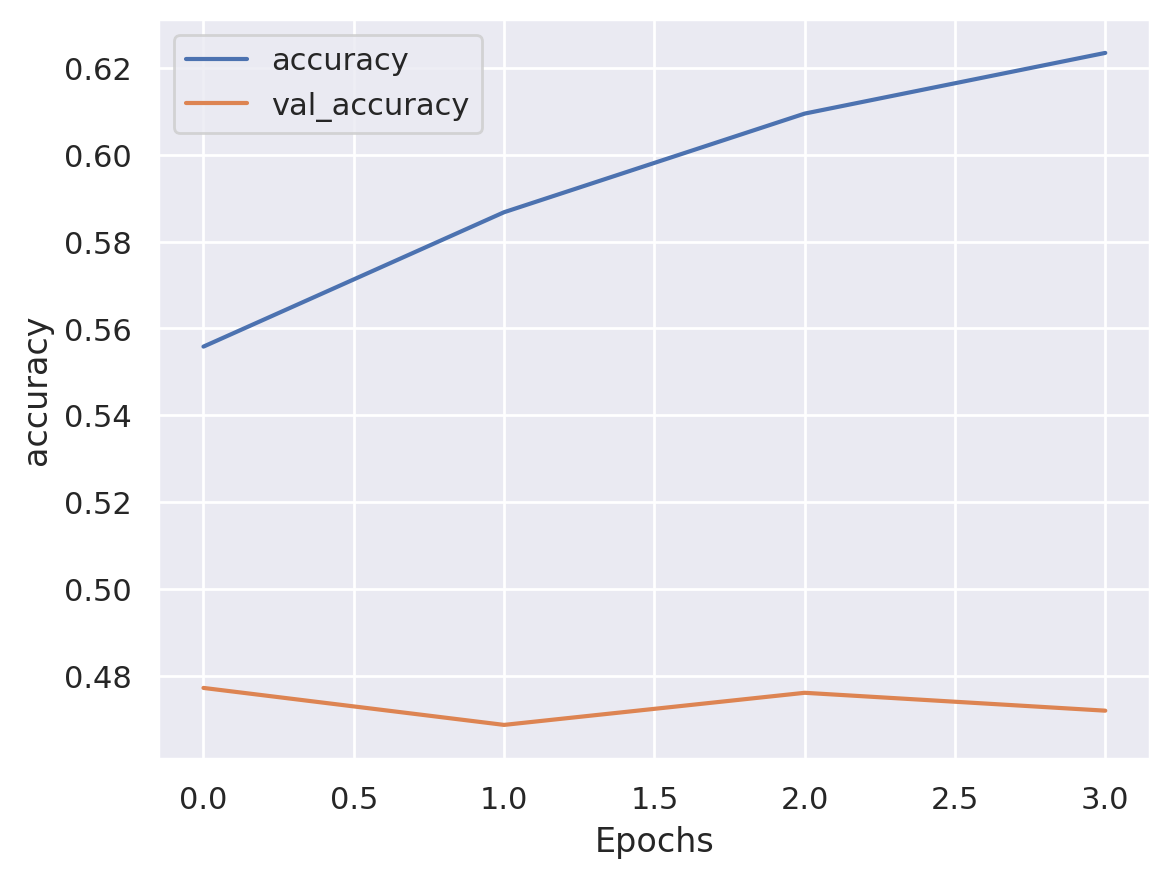

In [14]:
from utils.plot_utils import plot_history_metrics
plot_history_metrics(history, ['loss', 'accuracy'])

In [15]:
test_label_one_hot = tf.one_hot(test_label, 5)
model.evaluate(multi_hot_test_data,test_label_one_hot)

209/209 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.4740


[0.27492600679397583, 0.4739520847797394]

## Fazit

Wir kommen auf Out-of Samlple accuracy von 45%. Als Ziel haben wir uns 20 % Prozent gesetzt, weil wir 5 verschiedene Lables haben und alles drunter nur Raten wäre. Somit hat unsere Analyse das Ziel erreicht.